In [2]:
import numpy as np
import scipy as sp
from scipy.stats import poisson

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

##### Exercise 4.1

If $\pi$ is the equiprobable random policy, what is $Q^\pi(11, down)$, $Q^\pi(7, down)$?

We have $Q(s,a) = \sum_{s'} P^a_{ss'}[R^a_{ss'} + \gamma \sum_{a'} \pi(s', a') Q(s', a')]$, so

$$Q^\pi(11, down) = 1 [-1 + \gamma \cdot 1 \cdot 0] = -1$$

and

$$Q^\pi(7, down) = -1 + \gamma V^\pi(11) = -1 - 14 \cdot \gamma$$

##### Exercise 4.2

Suppose a new state 15 is added to the gridworld just below state 13, and its actions, left, up, right, and down, take the agent to states 12, 13, 14, and 15, respectively. Assume that the transitions from the original states are unchanged. What, then, is $V^\pi(15)$ for the equiprobable random policy?

$V^\pi(s) = \sum_a \pi(s,a) \sum_{s'} P^a_{ss'} [ R^a_{ss'} + \gamma V^\pi(s')]$

$V^\pi(15) = \frac{1}{4} [(-1 + \gamma V^\pi(12)) + (-1 + \gamma V^\pi(13)) + (-1 + \gamma V^\pi(14)) + (-1 + \gamma V^\pi(15))]$

$= \frac{1}{4}[ -4 + \gamma (V^\pi(12) + V^\pi(13) + V^\pi(14) + V^\pi(15))]$

so $V^\pi(15) = \frac{1}{1 - \frac{\gamma}{4}} [-1 + \frac{\gamma}{4} (V^\pi(12) + V^\pi(13) + V^\pi(14))]$

Now suppose the dynamics of state 13 are also changed, such that action down from state 13 takes the agent to the new state 15. What is $V^\pi(15)$ for the equiprobable random policy in this case?

It seems like we would need to do policy evaluation to find $V^\pi(15)$, since all value functions would change with the new state available? I'm not sure.

##### Exercise 4.3

What are the equations analogous to (4.3), (4.4), and (4.5) for the action-value function $Q^\pi$ and its successive approximation by a sequence of functions  $Q_0, Q_1, Q_2, ...$?

Using the Bellman Equation for $Q^\pi$,

$
\begin{equation}
\begin{split}
Q^\pi(s, a) =& E_\pi[\sum_{k=0}^{\infty} \gamma^k r_{t+k+1} | s_t = s, a_t = a]\\
=& E_\pi[r_{t+1} + \gamma \sum_{a'} \pi(s', a') Q^\pi(s', a')| s_t = s, a_t = a]\\
=& \sum_{s'} P^a_{ss'} [R^a_{ss'} + \gamma \sum_{a'} \pi(s', a') Q^\pi(s', a')]
\end{split}
\end{equation}
$

we obtain the following update equation:

$$Q_{k+1}(s, a) = \sum_{s'} P^a_{ss'} [R^a_{ss'} + \gamma \sum_{a'} \pi(s', a') Q_k(s', a')]$$

##### Exercise 4.3.5

In some undiscounted episodic tasks there may be policies for which eventual termination is not guaranteed. For example, in the grid problem above it is possible to go back and forth between two states forever. In a task that is otherwise perfectly sensible, $V^\pi(s)$ may be negative infinity for some policies and states, in which case the algorithm for iterative policy evaluation given in Figure  4.1 will not terminate. As a purely practical matter, how might we amend this algorithm to assure termination even in this case? Assume that eventual termination is guaranteed under the optimal policy.

We can threshold the min of $V^\pi(s)$ at a constant value so that $V^\pi(s)$ doesn't go to $-\infty$ since we know that states where $V^\pi(s) \rightarrow -\infty$ are actually terminal states that can't be escaped.


##### Exercise 4.4

https://webdocs.cs.ualberta.ca/~sutton/book/code/jacks.lisp

In [13]:
# ;;; Jack's car rental problem.  The state is n1 and n2, the number of cars
# ;;; at each location a the end of the day, at most 20.  Actions are numbers of cars 
# ;;; to switch from location 1 to location 2, a number between -5 and +5.

# ;;; P1(n1,new-n1) is a 26x21 array giving the probability that the number of cars at 
# ;;; location 1 is new-n1, given that it starts the day at n1.  Similarly for P2

# ;;; R1(n1) is a 26 array giving the expected reward due to satisfied requests at 
# ;;; location, given that the day starts with n1 cars at location 1.  SImilarly for R2.

            

The expected Rewards due to satisfied requests in a given state $n$ (state = number of cars available) at a parking lot are:

$$R_n = 10 \sum_{r=0}^{20} P(r) min(\{r, n\})$$

and the transition probability that the number of cars at a location is $n'$ after starting at $n$ is

$$P(n, n') = \sum_{r=0} P(r) \sum_{d=0} P(d) \delta(r = n, n' = min(\{20, n + d - req_{satisfied}\}))$$

for all requests $r$ and dropoffs $d$.

In [50]:
class JacksCarRental(object):
    def __init__(self):
        
        self.lambda_requests1 = 3
        self.lambda_requests2 = 4
        self.lambda_dropoffs1 = 3
        self.lambda_dropoffs2 = 2

        self.gamma = 0.9            # discount factor
        self.theta = 0.0000001      # delta precision for policy evaluation

        # value function
        self.V = np.zeros((21, 21))
        self.Vs = [self.V]
        # policy
        self.PI = np.zeros((21, 21))
        self.PIs = [self.PI]

        # transition probabilities for each state
        self.P1 = np.zeros((26, 21))
        self.P2 = np.zeros((26, 21))

        # expected rewards in each state
        self.R1 = np.zeros(26)
        self.R2 = np.zeros(26)
        
        # calculate trans. probs and expected rewards
        self.P1, self.R1 = self.load_P_and_R(
            self.P1, self.R1,
            lambda_requests=self.lambda_requests1,
            lambda_dropoffs=self.lambda_dropoffs1
        )

        self.P2, self.R2 = self.load_P_and_R(
            self.P2, self.R2,
            lambda_requests=self.lambda_requests2,
            lambda_dropoffs=self.lambda_dropoffs2
        )
        
    def load_P_and_R(self, P, R, lambda_requests, lambda_dropoffs):
        # Get the transition probabilities and expected rewards
        requests = 0
        request_prob = poisson.pmf(requests, mu=lambda_requests)
        while request_prob >= .000001:
            # expected rewards
            for n in xrange(26):
                # rent out car for $10 each
                R[n] += 10 * request_prob * min([requests, n])

            # transition probabilities
            dropoffs = 0
            dropoff_prob = poisson.pmf(dropoffs, mu=lambda_dropoffs)
            while dropoff_prob >= .000001:
                for n in xrange(26):
                    satisfied_requests = min([requests, n])
                    new_n = min([20, n + dropoffs - satisfied_requests])
                    if new_n < 0:
                        print 'Warning negative new_n', new_n
                    P[n, new_n] += request_prob * dropoff_prob

                dropoffs += 1
                dropoff_prob = poisson.pmf(dropoffs, mu=lambda_dropoffs)

            requests += 1
            request_prob = poisson.pmf(requests, mu=lambda_requests)

        return P, R
        
    # 2. policy evaluation
    def backup_action(self, n1, n2, a):
        # number of cars to move from location 1 to 2, thresholded at 5 and -5 according to problem specs
        cars_to_move = max([min([n1, a]), -n2])
        cars_to_move = min([max([cars_to_move, -5]), 5])

        # costs $2 to move each cars
        cost_to_move = -2 * abs(cars_to_move)

        # do backup
        morning_n1 = n1 - cars_to_move
        morning_n2 = n2 + cars_to_move

        # sum over all possible next states
        newv = 0
        for newn1 in xrange(21):
            for newn2 in xrange(21):
                newv += self.P1[morning_n1, newn1] * self.P2[morning_n2, newn2] *\
                        (self.R1[morning_n1] + self.R2[morning_n2] +\
                         self.gamma * self.V[newn1, newn2])
        return newv + cost_to_move

    def policy_evaluation(self):
        delta = 1
        while delta > self.theta:
            delta = 0
            # Loop through all States
            for n1 in xrange(21):
                for n2 in xrange(21):
                    old_v = self.V[n1, n2]
                    action = self.PI[n1, n2]
                    # do a full backup for each state
                    self.V[n1, n2] = self.backup_action(n1, n2, action)
                    delta = max([delta, abs(old_v - self.V[n1, n2])])
#             print 'Policy evaluation delta: ', delta
        print 'Done with Policy Evaluation'
        return self.V
    
    # 3. Policy Improvement
    def get_best_policy(self, n1, n2):
        best_value = -1
        for a in range(max(-5, -n2), min(5, n1) + 1):
            this_action_value = self.backup_action(n1, n2, a)
            if this_action_value > best_value:
                best_value = this_action_value
                best_action = a

        return best_action

    def policy_improvement(self):
        self.V = self.policy_evaluation()
        policy_stable = False
        while policy_stable is False:
            policy_stable = True
            for n1 in xrange(21):
                for n2 in xrange(21):
                    b = self.PI[n1, n2]
                    self.PI[n1, n2] = self.get_best_policy(n1, n2)

                    if b != self.PI[n1, n2]:
                        policy_stable = False

            self.Vs.append(self.policy_evaluation())
            self.PIs.append(self.PI)

        return policy_stable

In [61]:
# Policy Iteration for Jack's Car Rental problem

jacks = JacksCarRental()
V = jacks.policy_improvement()

/Applications/anaconda/envs/rl/lib/python2.7/site-packages/ipykernel/__main__.py:85: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Done with Policy Evaluation
Done with Policy Evaluation
Done with Policy Evaluation
Done with Policy Evaluation
Done with Policy Evaluation
Done with Policy Evaluation


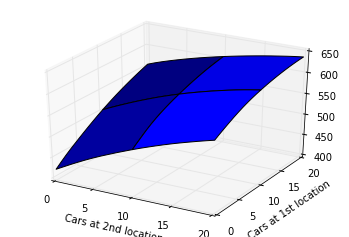

In [68]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xv, yv = np.meshgrid(range(21), range(21))
ax.plot_surface(xv, yv, jacks.V)
ax.set_xlabel('Cars at 2nd location')
ax.set_ylabel('Cars at 1st location')


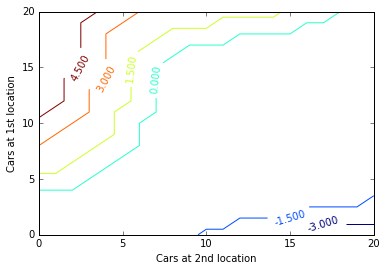

In [69]:
plt.figure()
cs = plt.contour(xv, yv, jacks.PI)
plt.clabel(cs, inline=1, fontsize=10)
plt.xlabel('Cars at 2nd location')
plt.ylabel('Cars at 1st location')

One of Jack's employees at the first location rides a bus home each night and lives near the second location. She is happy to shuttle one car to the second location for free. Each additional car still costs \$2, as do all cars moved in the other direction. In addition, Jack has limited parking space at each location. If more than 10 cars are kept overnight at a location (after any moving of cars), then an additional cost of \$4 must be incurred to use a second parking lot (independent of how many cars are kept there). 

In [90]:
class JacksCarRental(object):
    def __init__(self):
        
        self.lambda_requests1 = 3
        self.lambda_requests2 = 4
        self.lambda_dropoffs1 = 3
        self.lambda_dropoffs2 = 2

        self.gamma = 0.9            # discount factor
        self.theta = 0.0000001      # delta precision for policy evaluation

        # value function
        self.V = np.zeros((21, 21))
        self.Vs = [self.V]
        # policy
        self.PI = np.zeros((21, 21))
        self.PIs = [self.PI]

        # transition probabilities for each state
        self.P1 = np.zeros((26, 21))
        self.P2 = np.zeros((26, 21))

        # expected rewards in each state
        self.R1 = np.zeros(26)
        self.R2 = np.zeros(26)
        
        # calculate trans. probs and expected rewards
        self.P1, self.R1 = self.load_P_and_R(
            self.P1, self.R1,
            lambda_requests=self.lambda_requests1,
            lambda_dropoffs=self.lambda_dropoffs1
        )

        self.P2, self.R2 = self.load_P_and_R(
            self.P2, self.R2,
            lambda_requests=self.lambda_requests2,
            lambda_dropoffs=self.lambda_dropoffs2
        )
        
    def load_P_and_R(self, P, R, lambda_requests, lambda_dropoffs):
        # Get the transition probabilities and expected rewards
        requests = 0
        request_prob = poisson.pmf(requests, mu=lambda_requests)
        while request_prob >= .000001:
            # expected rewards
            for n in xrange(26):
                # rent out car for $10 each
                R[n] += 10 * request_prob * min([requests, n])

            # transition probabilities
            dropoffs = 0
            dropoff_prob = poisson.pmf(dropoffs, mu=lambda_dropoffs)
            while dropoff_prob >= .000001:
                for n in xrange(26):
                    satisfied_requests = min([requests, n])
                    new_n = min([20, n + dropoffs - satisfied_requests])
                    if new_n < 0:
                        print 'Warning negative new_n', new_n
                    P[n, new_n] += request_prob * dropoff_prob

                dropoffs += 1
                dropoff_prob = poisson.pmf(dropoffs, mu=lambda_dropoffs)

            requests += 1
            request_prob = poisson.pmf(requests, mu=lambda_requests)

        return P, R
        
    # 2. policy evaluation
    def backup_action(self, n1, n2, a):
        # number of cars to move from location 1 to 2, thresholded at 5 and -5 according to problem specs
        cars_to_move = max([min([n1, a]), -n2])
        cars_to_move = min([max([cars_to_move, -5]), 5])

        # costs $2 to move each car, 
        # but we get one car free if we move from n1 to n2!
        cost_to_move = -2 * abs(cars_to_move)
        
        if cars_to_move > 0:
            # 1 free one if we move n1 -> n2
            cost_to_move += 2
        
        # do backup
        morning_n1 = n1 - cars_to_move
        morning_n2 = n2 + cars_to_move
        
        # If more than 10 cars are kept overnight at a location (after any moving of cars), 
        # then an additional cost of \$4 must be incurred
        extra_parking_cost = 0
        if morning_n1 > 10:
            extra_parking_cost -= 4
        if morning_n2 > 10:
            extra_parking_cost -= 4

        # sum over all possible next states
        newv = 0
        for newn1 in xrange(21):
            for newn2 in xrange(21):
                newv += self.P1[morning_n1, newn1] * self.P2[morning_n2, newn2] *\
                        (self.R1[morning_n1] + self.R2[morning_n2] +\
                         self.gamma * self.V[newn1, newn2])
        return newv + cost_to_move + extra_parking_cost

    def policy_evaluation(self):
        delta = 1
        while delta > self.theta:
            delta = 0
            # Loop through all States
            for n1 in xrange(21):
                for n2 in xrange(21):
                    old_v = self.V[n1, n2]
                    action = self.PI[n1, n2]
                    # do a full backup for each state
                    self.V[n1, n2] = self.backup_action(n1, n2, action)
                    delta = max([delta, abs(old_v - self.V[n1, n2])])
#             print 'Policy evaluation delta: ', delta
        print 'Done with Policy Evaluation'
        return self.V
    
    # 3. Policy Improvement
    def get_best_policy(self, n1, n2):
        best_value = -1
        for a in range(max(-5, -n2), min(5, n1) + 1):
            this_action_value = self.backup_action(n1, n2, a)
            if this_action_value > best_value:
                best_value = this_action_value
                best_action = a

        return best_action

    def policy_improvement(self):
        self.V = self.policy_evaluation()
        policy_stable = False
        while policy_stable is False:
            policy_stable = True
            for n1 in xrange(21):
                for n2 in xrange(21):
                    b = self.PI[n1, n2]
                    self.PI[n1, n2] = self.get_best_policy(n1, n2)

                    if b != self.PI[n1, n2]:
                        policy_stable = False

            self.Vs.append(np.copy(self.policy_evaluation()))
            self.PIs.append(np.copy(self.PI))

        return policy_stable

In [91]:
jacks = JacksCarRental()
V = jacks.policy_improvement()

/Applications/anaconda/envs/rl/lib/python2.7/site-packages/ipykernel/__main__.py:99: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Done with Policy Evaluation
Done with Policy Evaluation
Done with Policy Evaluation
Done with Policy Evaluation
Done with Policy Evaluation
Done with Policy Evaluation


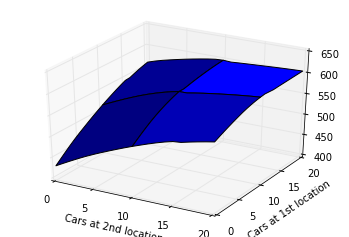

In [97]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xv, yv = np.meshgrid(range(21), range(21))
ax.plot_surface(xv, yv, jacks.V)
ax.set_xlabel('Cars at 2nd location')
ax.set_ylabel('Cars at 1st location')


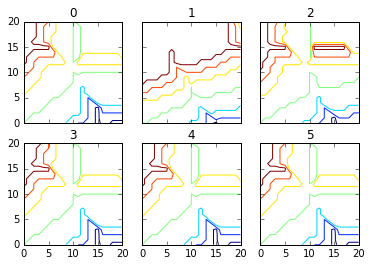

In [122]:
f, axx = plt.subplots(2, 3, sharex='col', sharey='row')

for i in xrange(len(jacks.PIs)):
    r = i / 3
    c = i % 3
    ax = axx[r, c]
    cs = ax.contour(xv, yv, jacks.PIs[i])
    ax.set_title(i)

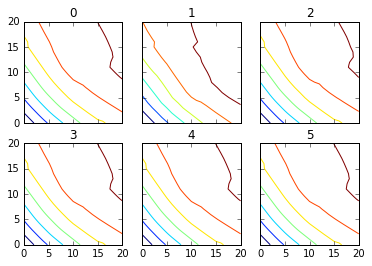

In [121]:
f, axx = plt.subplots(2, 3, sharex='col', sharey='row')

for i in xrange(len(jacks.Vs)):
    r = i / 3
    c = i % 3
    ax = axx[r, c]
    cs = ax.contour(xv, yv, jacks.Vs[i])
    ax.set_title(i)
#     ax.set_clabel(cs, inline=1, fontsize=10)
#     ax.set_xlabel('Cars at 2nd location')
#     ax.set_ylabel('Cars at 1st location')

##### 4.5 
How would policy iteration be defined for action values? Give a complete algorithm for computing $Q^*$, analogous to Figure  4.3 for computing $V^*$. Please pay special attention to this exercise, because the ideas involved will be used throughout the rest of the book.


I'm not sure about step 3??, but I'm trying to use $\pi(s,a)$ as a deterministic probability of taking an action in a given state.

1. Initialization
    - $Q(s,a) \in \mathbb{R}$ and $\pi(s, a) \in \{0, 1\}$ arbitrarily for all $s \in S$ and $a \in A(s)$
2. Policy Evaluation    
    - Repeat
        - $\Delta \leftarrow 0$
        - For each $s \in S$ and $a \in A(s)$
            - $q \leftarrow Q(s,a)$
            - $Q(s,a) \leftarrow \sum_{s'} P^a_{ss'}[R^a_{ss'} + \gamma \sum_{a'} \pi(s', a') Q(s', a')]$
            - $\Delta \leftarrow max(\Delta, |q - Q(s,a)|)$
    - Until $\Delta \lt \theta$

3. Policy Improvement
    - policy_stable = True
    - For each $s \in S$ and $a \in A(s)$
        - $b \leftarrow Q(s,a)$
        - $\pi(s,a) \leftarrow \sum_{s'} P^a_{ss'} [R^a_{ss'} + \gamma \cdot argmax_{a'} Q(s', a')] $
        - If $b \neq \pi(s, a)$, then policy_stable = False
    - For each $s \in S$ and $a \in A(s)$
        - $\pi(s,a) \leftarrow$ 1 if $\pi(s,a) = argmax_a \pi(s,a)$ else 0
    - If policy_stable, then stop, else go to 2
    

##### Exercise 4.6   

Suppose you are restricted to considering only policies that are $\epsilon$-soft, meaning that the probability of selecting each action in each state, $s$, is at least $\epsilon / |A(s)|$. Describe qualitatively the changes that would be required in each of the steps 3, 2, and 1, in that order, of the policy iteration algorithm for  (Figure  4.3).


Step 3 would still take greedy updates to $\pi(s, a)$, but would have to make sure that $\pi(s,a)$ has at least a probability of $\epsilon / |A(s)|$ for each non-greedy action. $\pi(s,a)$ is the probability of taking action $a$ in state $s$, as opposed to $\pi(s)$ as used previously since we had deterministic policies. Step 2 would have to use the Bellman Equation for $V(s)$ with a non-deterministic policy evaluation, $V(s) \leftarrow \sum_a \pi(s,a) \sum_{s'} P^a_{ss'} [R^a_{ss'} + \gamma V(s')]$. Step 1 would have to initiliaze the $\pi(s,a)$ as random uniform.

##### Exercise 4.7

Why does the optimal policy for the gambler's problem have such a curious form? In particular, for capital of 50 it bets it all on one flip, but for capital of 51 it does not. Why is this a good policy?

If p >= .5, then you'd want to bet 1 at all states, since you are more likely to win than lose. If p < .5, then you are more likely to lose on any bet than to win. The reason that at p=.4, the policy has a weird shape, is because at state 2 for example, it is more likely that you get to state 4 by betting $2 than by betting $1 twice. The probability of going from state 2 to state 4 in one time-step by betting $1 twice is .4*.4=.16, which is less than if you bet $2 once. 

The spikes on 12, 25, 50, and 75, seem empirically independent of p as long as p is greater than around .05. This suggests that the spikes around those values exist because the game terminates at 100. You are more likely to get to 100 if you bet values that are factors of 100. Since there is no state > 100, the optimal policy has this jagged form.

##### Exercise 4.8

 Implement value iteration for the gambler's problem and solve it for p=.25 and p=.55. In programming, you may find it convenient to introduce two dummy states corresponding to termination with capital of 0 and 100, giving them values of 0 and 1 respectively. Show your results graphically, as in Figure  4.6. Are your results stable as $\theta \rightarrow 0$?
 
 

In [165]:
class GamblersProblem(object):
    def __init__(self, p=.45, gamma=1):
        self.PI = np.zeros(100)
        self.V = np.zeros(101)
        self.gamma = gamma
        self.p = p
        
    def backup_action(self, state, action):
        return self.p * self.gamma * self.V[state + action] +\
                (1 - self.p) * self.gamma * self.V[state - action]
    
    def value_iteration(self, epsilon=.0000000001):
        self.V = np.zeros(101)
        # You get a reward of 1 if you win $100
        self.V[100] = 1

        delta = 1
        while delta > epsilon:
            delta = 0
            for state in xrange(1, 100):
                old_v = self.V[state]
                # you can bet up to all your money as long as the winnings would be less than 100
                self.V[state] = np.max(
                    [self.backup_action(state, action + 1) \
                     for action in xrange(min(state, 100 - state))]
                )
                delta = max(delta, abs(self.V[state] - old_v))

    def get_deterministic_policy(self, epsilon=.0000000001):
        PI = np.zeros(100)
        for state in xrange(1, 100):
            values = [self.backup_action(state, action + 1)\
                               for action in xrange(min(state, 100 - state))]

            best_pi = 1
            best_value = -1
            for idx, v in enumerate(values):
                if v > best_value + epsilon:
                    best_value = v
                    best_pi = idx + 1
            
            PI[state] = best_pi

        self.PI = PI
        return PI
    

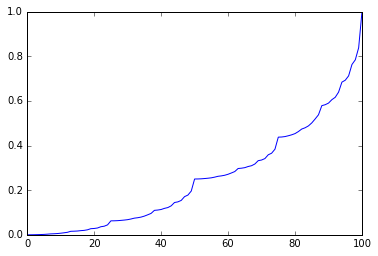

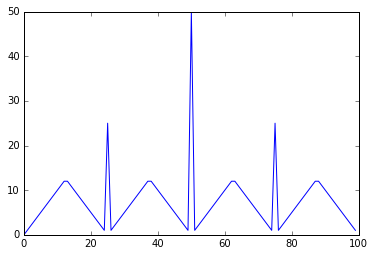

In [166]:
gp = GamblersProblem(p=.25)
gp.value_iteration()
plt.plot(gp.V)
plt.show()
plt.plot(gp.get_deterministic_policy())
plt.show()

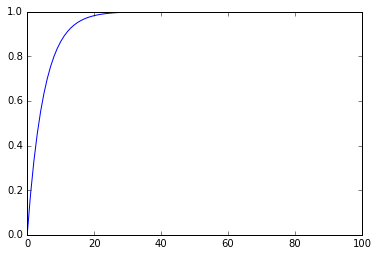

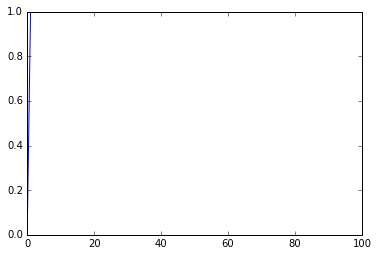

In [167]:
gp = GamblersProblem(p=.55)
gp.value_iteration()
plt.plot(gp.V)
plt.show()
plt.plot(gp.get_deterministic_policy())
plt.show()

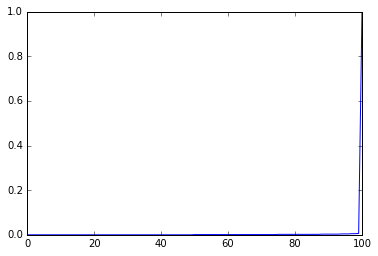

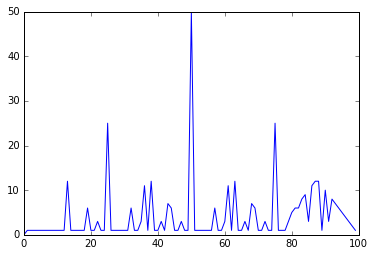

In [168]:
gp = GamblersProblem(p=.001)
gp.value_iteration()
plt.plot(gp.V)
plt.show()
plt.plot(gp.get_deterministic_policy())
plt.show()

Results are not stable as $\theta \rightarrow 0$, I'm not really sure why.

##### Exercise 4.9

What is the analog of the value iteration backup (4.10) for action values, $Q_{k+1}(s,a)$?


- Initialize Q arbitrarily, e.g. $Q(s,a)=0$ for all $s \in S$ and $a \in A(s)$
- Repeat
    - $\Delta \leftarrow 0$
    - For each $s \in S$ and $a \in A(s)$
        - $q \leftarrow Q(s,a)$
        - $Q(s,a) = \sum_{s'} P^a_{ss'} [R^a_{ss'} + \gamma \cdot argmax_{a'} Q(s', a')]$
        - $\Delta \leftarrow max(\Delta, |q - Q(s,a)|)$
- until $\Delta \lt \theta$

- Output a deterministic policy $\pi$ such that
    - $\pi(s) = argmax_a Q(s,a)$ 